# Adult income dataset

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker
(Data Mining and Visualization, Silicon Graphics).
**The prediction task is to determine whether a person makes over $50K a year.**

In [1]:
import missingno
import os
import requests
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, train_test_split, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef

sns.set(context='notebook')

## Load dataset

In [2]:
DATASET = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
)


def download_data(path='dataset', urls=DATASET):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        response = requests.get(url)
        name = os.path.basename(url)
        with open(os.path.join(path, name), 'wb') as f:
            f.write(response.content)

# download_data()

In [3]:
headers = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation',
           'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']
training_raw = pd.read_csv(
    'dataset/adult.data',
    header=None,
    names=headers,
    sep=',\s',
    na_values=["?"],
    engine='python'
)
test_raw = pd.read_csv(
    'dataset/adult.test',
    header=None,
    names=headers,
    sep=',\s',
    na_values=["?"],
    engine='python',
    skiprows=1
)

In [4]:
dataset = pd.concat([training_raw, test_raw])
dataset.reset_index(inplace=True)
dataset.drop('index', inplace=True, axis=1)

In [5]:
dataset.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
dataset.describe(include=['O'])

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,46043,48842,48842,46033,48842,48842,48842,47985,48842
unique,8,16,7,14,6,5,2,41,4
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,24720


In [7]:
dataset.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<AxesSubplot:>

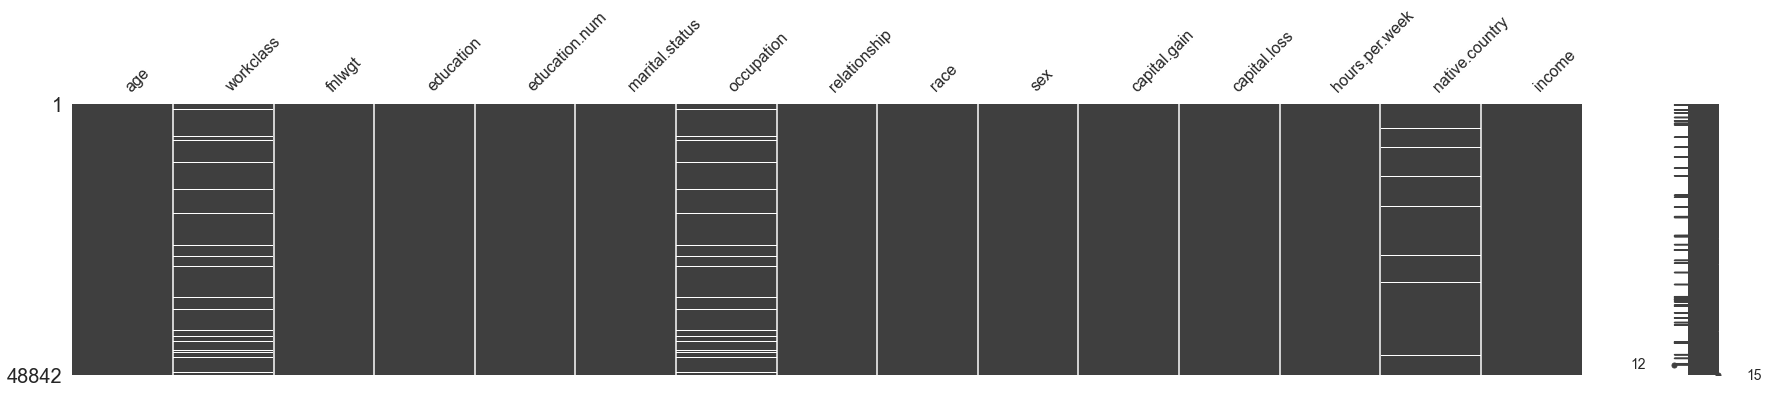

In [8]:
missingno.matrix(dataset, figsize=(30, 5))

In [9]:
dataset['income'] = dataset['income'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})
dataset.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## Data analysis


In [10]:
numeric_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'income']
cat_features = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native']

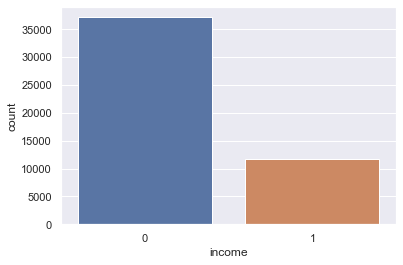

In [11]:
sns.countplot(x=dataset['income'])
plt.show()

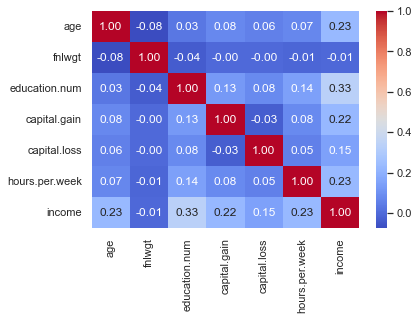

In [12]:
sns.heatmap(dataset[numeric_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

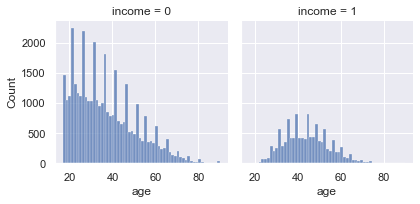

In [13]:
g = sns.FacetGrid(dataset, col='income')
g = g.map(sns.histplot, "age")
plt.show()

In [14]:
dataset["workclass"] = dataset["workclass"].fillna("X")
dataset["occupation"] = dataset["occupation"].fillna("X")
dataset["native.country"] = dataset["native.country"].fillna("United-States")

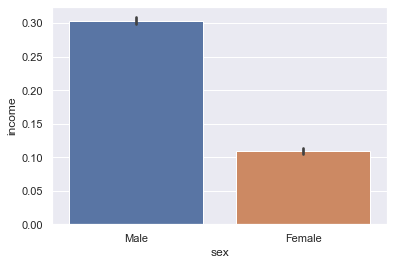

In [15]:
sns.barplot(x="sex", y="income", data=dataset)
plt.show()

### Feature Engineering

In [16]:
dataset["sex"] = dataset["sex"].map({"Male": 0, "Female": 1})

dataset["marital.status"] = dataset["marital.status"].replace(['Never-married', 'Divorced', 'Separated', 'Widowed'],
                                                              'Single')
dataset["marital.status"] = dataset["marital.status"].replace(
    ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'], 'Married')
dataset["marital.status"] = dataset["marital.status"].map({"Married": 1, "Single": 0})
dataset["marital.status"] = dataset["marital.status"].astype(int)

In [17]:
dataset = dataset.drop(labels=["workclass", "education", "relationship"], axis=1)

In [18]:
dataset = pd.get_dummies(dataset)

In [19]:
dataset.head()

,age,fnlwgt,education.num,marital.status,sex,capital.gain,capital.loss,hours.per.week,income,occupation_Adm-clerical,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,39,77516,13,0,0,2174,0,40,0,1,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,1,0,0,0,13,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,0,0,40,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,1,0,0,0,40,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,1,1,0,0,40,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model

In [20]:
VALIDATION_SIZE = 0.2
SEED = 42
num_folds = 10

# Random Forest
num_trees = 100
max_features = 3

In [21]:
scoring = {'accuracy': 'accuracy', 'f1': 'f1', 'mcc': make_scorer(matthews_corrcoef)}

In [22]:
models = [
    ('LR', LogisticRegression()),
    ('DT', DecisionTreeClassifier()),
    ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
]

In [23]:
X = dataset.drop(['income'], axis=1)
y = dataset['income'].astype('int64')
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=VALIDATION_SIZE, random_state=SEED)

In [24]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)
    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)


In [25]:
for name, result in zip(names, results):
    print(name)
    print(f'\tAccuracy: {round(result["test_accuracy"].mean(), 4)} ({round(result["test_accuracy"].std(), 4)})')
    print(f'\tF1: {round(result["test_f1"].mean(), 4)} ({round(result["test_f1"].std(), 4)})')
    print(f'\tMCC: {round(result["test_mcc"].mean(), 4)} ({round(result["test_mcc"].std(), 4)})')

LR
	Accuracy: 0.7981 (0.0077)
	F1: 0.3822 (0.0135)
	MCC: 0.3433 (0.0127)
DT
	Accuracy: 0.8176 (0.0084)
	F1: 0.6208 (0.0145)
	MCC: 0.5008 (0.0193)
RF
	Accuracy: 0.8495 (0.0059)
	F1: 0.6535 (0.0125)
	MCC: 0.5634 (0.0145)
